In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as sl

#bempp.api.enable_console_logging()

Setting the size of the element of the mesh and the center of the two spheres. The radius of the sphere is 1 and the distance between the boundary of them if 1. (Z/R=1)

In [2]:
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) 

We are defining an exponentially adapted trapezoid rule and choose the quadrature points accordingly.

In [3]:
size_mesh = [0.4,0.35,0.3,0.25,0.2,0.15,0.1]
N = 5
lbound = .05
ubound = 4
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
result_ratio1 = np.empty((len(size_mesh),N), dtype='float64')
result2_ratio1 = np.empty((len(size_mesh),N), dtype='float64')
result3_ratio1 = np.empty((len(size_mesh),N), dtype='float64')



for index1, h in enumerate(size_mesh):
    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    for index2, point in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

        blocked_op = BlockedOperator(2, 2)
        blocked_op[0, 0] = op11
        blocked_op[0, 1] = op12
        blocked_op[1, 0] = op21
        blocked_op[1, 1] = op22

        blocked_diag = BlockedOperator(2, 2)
        blocked_diag[0, 0] = op11
        blocked_diag[1, 1] = op22

        mat = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
        mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
        combined = np.linalg.inv(mat2).dot(mat)
        sign, logdet = slogdet(combined)
        result_ratio1[index1,index2] = logdet 
#===================================================================================================
        P1,L1,U1 = sl.lu(mat)
        logdet1 = 0
        for i in range(mat.shape[0]):
            logdet1 += np.log(abs(U1[i,i]))

        P2,L2,U2 = sl.lu(np.real(bempp.api.as_matrix(op11.weak_form())))
        logdet2 = 0
        a = np.real(bempp.api.as_matrix(op11.weak_form())).shape[0]
        for i in range(a):
            logdet2 += np.log(abs(U2[i,i]))

        P3,L3,U3 = sl.lu(np.real(bempp.api.as_matrix(op22.weak_form())))
        logdet3 = 0
        b = np.real(bempp.api.as_matrix(op22.weak_form())).shape[0]
        for i in range(b):
            logdet3 += np.log(abs(U3[i,i]))
        result2 = logdet1 - logdet2 - logdet3
        result2_ratio1[index1,index2] = result2
#===================================================================================================
        w1,v1 = np.linalg.eig(mat)
        w2,v2 = np.linalg.eig(mat2)
        result3 = 0
        for i in range(mat.shape[0]):
            result3 += np.log(abs(w1[i])) - np.log(abs(w2[i]))
        result3_ratio1[index1,index2] = result3
        print( result_ratio1[index1,index2], result2_ratio1[index1,index2], result3_ratio1[index1,index2] , index1, index2)

-3.089653860956003e-05 -3.089653705501405e-05 -3.0896538750546654e-05 0 0
-0.00480595766176407 -0.004805957661801585 -0.004805957660890314 0 1
-0.012706191373751754 -0.012706191374149967 -0.012706191374659781 0 2
-0.01778690425148135 -0.01778690425089735 -0.017786904252195868 0 3
-0.019255395389527624 -0.01925539533783649 -0.019255395218539917 0 4
-3.5430195659594366e-05 -3.5430199659458594e-05 -3.5430196359431676e-05 1 0
-0.005131178653844941 -0.005131178653073221 -0.0051311786533068116 1 1
-0.01340356337293151 -0.013403563375277372 -0.013403563371649163 1 2
-0.01869839164187794 -0.018698391641464696 -0.018698391643692247 1 3
-0.020233929045081842 -0.02023392899764076 -0.020233929688314944 1 4
-3.775941222725181e-05 -3.77594069504994e-05 -3.775941052230891e-05 2 0
-0.005288397701801114 -0.005288397700496716 -0.005288397702641667 2 1
-0.01373697560783218 -0.01373697560347864 -0.013736975609601743 2 2
-0.019132940928371783 -0.019132940930830955 -0.019132940918466623 2 3
-0.0207007036623

In [4]:
%matplotlib inline
from matplotlib.pyplot import figure

The left plot shows the relative log determinant with increasing imaginary wavenumber. The right plot uses a scale appropriate for the trapezoid quadrature rule.

In [5]:
Casimir_energy1 = []
for i in range(len(size_mesh)):
    Casimir_energy1.append(np.trapz(-result_ratio1[i,:] / quad_points, quad_points) / (2 * np.pi))
    
Casimir_energy2 = []
for i in range(len(size_mesh)):
    Casimir_energy2.append(np.trapz(-result2_ratio1[i,:] / quad_points, quad_points) / (2 * np.pi))
    
Casimir_energy3 = []
for i in range(len(size_mesh)):
    Casimir_energy3.append(np.trapz(-result3_ratio1[i,:] / quad_points, quad_points) / (2 * np.pi))

In [12]:
Casimir_energy1 #slogdet

[0.003008681940325356,
 0.003180880961470681,
 0.0032635440009760167,
 0.0033227669826967027,
 0.003364066139898666,
 0.003429518899475958,
 0.0034678888208614037]

In [13]:
Casimir_energy2 #thesis

[0.0030086819377473663,
 0.0031808809646425946,
 0.003263543992167167,
 0.00332276699211328,
 0.0033640661540488073,
 0.0034295188878661086,
 0.00346788883168795]

In [14]:
Casimir_energy3 #eigenvalue

[0.0030086819371095584,
 0.0031808809746463607,
 0.0032635439990863283,
 0.0033227669793130543,
 0.003364066152715323,
 0.0034295189580082082,
 0.003467888780016548]

In [25]:
Casimir_energy4 #H-lu

[0.0030086819407810234,
 0.00318088096152051,
 0.0032635439976815275,
 0.0033227669847835754,
 0.0033640661548929368,
 0.0034295188921304805,
 0.0034678888766351518]

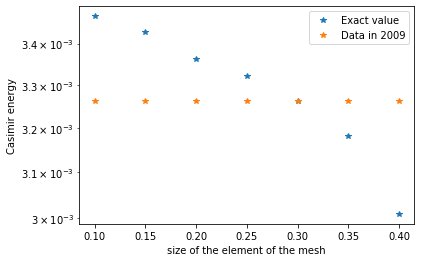

In [33]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.10f'))
plt.semilogy(size_mesh,Casimir_energy1,'*')
plt.semilogy(size_mesh,(Casimir_energy4[2],Casimir_energy4[2],Casimir_energy4[2],Casimir_energy4[2],Casimir_energy4[2],Casimir_energy4[2],Casimir_energy4[2]),'*')

plt.legend(['Exact value', 'Data in 2009'])

plt.xlabel('size of the element of the mesh')
plt.ylabel('Casimir energy')
plt.savefig('Convergence_ratio1.pdf',bbox_inches='tight')

In [11]:
rate_conv1 = [] #linearly convergence
for i in range(6):
    rate_conv1.append(abs((Casimir_energy1[i+2]-Casimir_energy1[0]))/abs((Casimir_energy1[i+1]-Casimir_energy1[0])))

In [12]:
rate_conv1

[1.480043608584589,
 1.2323726865014357,
 1.131490366080964,
 1.1841746472011903,
 1.0911752652687392,
 1.0594785331479726]

In [22]:
result4_ratio1 = np.empty((len(size_mesh),N), dtype='float64')

for index1, h in enumerate(size_mesh):
    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    for index2, point in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

        mat11 = np.real(bempp.api.as_matrix(op11.weak_form()))
        mat12 = np.real(bempp.api.as_matrix(op12.weak_form()))
        mat21 = np.real(bempp.api.as_matrix(op21.weak_form()))
        mat22 = np.real(bempp.api.as_matrix(op22.weak_form()))

        a22 = np.identity(mat22.shape[0])
        a12 = np.linalg.inv(mat11) @ mat12
        a21 = np.linalg.inv(mat22) @ mat21

        P22,L22,U22 = sl.lu(a22 - a21 @ a12) 

        result4 = 0
        for i in range(L22.shape[0]):
            result4 += np.log(abs(L22[i,i]))
        for j in range(U22.shape[0]):
            result4 +=np.log(abs(U22[j,j]))
        result4_ratio1[index1,index2] = result4

        print( result4_ratio1[index1,index2], index1, index2)

-3.0896538625769295e-05 0 0
-0.00480595766174892 0 1
-0.012706191373751967 0 2
-0.017786904250835598 0 3
-0.01925539541386459 0 4
-3.543019566081562e-05 1 0
-0.005131178653900343 1 1
-0.013403563372935488 1 2
-0.01869839164174094 1 3
-0.020233929047500637 1 4
-3.775941221459528e-05 2 0
-0.005288397701874605 2 1
-0.013736975606937697 2 2
-0.019132940930271333 2 3
-0.020700703492044493 2 4
-3.934031906351623e-05 3 0
-0.005400258189295556 3 1
-0.013977415615051156 3 2
-0.019445859004223 3 3
-0.021035181890733518 3 4
-4.029273993502729e-05 4 0
-0.0054777559764559326 4 1
-0.014147053045213069 4 2
-0.019665542000569837 4 3
-0.021268454370368287 4 4
-4.210490844929186e-05 5 0
-0.005602498173443653 5 1
-0.014411535005832914 5 2
-0.020009304832418404 5 3
-0.021636706125890495 5 4
-4.315351398180416e-05 6 0
-0.00567546791083844 6 1
-0.014566956262491437 6 2
-0.02021104625900877 6 3
-0.02185243136185712 6 4


In [23]:
Casimir_energy4 = []
for i in range(len(size_mesh)):
    Casimir_energy4.append(np.trapz(-result4_ratio1[i,:] / quad_points, quad_points) / (2 * np.pi))